### Análises atuais:
 * Cursos com mais emprestimos cadastrados (por nível do curso)
 * Número de emprestimos por ano ()
 * Tempo dos emprestimos (e algumas estatisticas)
 * 

In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Lendo os dados dos emprestimos
Dados_Emprestimos = glob("Dados_Abertos/Dados_Emprestimos/*.csv")
emprestimos = [pd.read_csv(f, sep=';') for f in sorted(Dados_Emprestimos)]

In [3]:
# Lendo os dados dos discentes
Dados_Discentes = glob("Dados_Abertos/Dados_Discentes/*.csv")
discentes = [pd.read_csv(f, sep=';') for f in sorted(Dados_Discentes)]

In [4]:
# Lendo os dados do acervo da biblioteca
acervo = pd.read_csv("Dados_Abertos/Dados_Biblioteca/acervo.csv", sep=';')
exemplares = pd.read_csv("Dados_Abertos/Dados_Biblioteca/exemplares.csv", sep=';')
exemplares_acervo = pd.read_csv("Dados_Abertos/Dados_Biblioteca/exemplares-acervo.csv", sep=';')

In [5]:
# Adicionando coluna 'ano' aos datasets 
so = sorted(Dados_Emprestimos)
for r in range(len(so)):
    emprestimos[r]['ano'] = int(so[r][-9:-5])
    
anos = []
for r in range(len(so)):
    anos.append(int(so[r][-9:-5]))

In [6]:
# Concatenando os datasets obtidos
emprestimos_all = pd.concat(emprestimos, ignore_index=True)
discentes_all = pd.concat(discentes, ignore_index=True)

# Filtrando dados a serem considerados
emprestimos_all = emprestimos_all[emprestimos_all.nome_usuario != "Usuário de Migração"]
discentes_curso = discentes_all[['nome_discente','ano_ingresso','nome_curso', 'nivel_ensino']]
discentes_curso = discentes_curso.set_index(['nome_discente','ano_ingresso'])

In [7]:
# Obtendo o numero de emprestimos de cada usuario por ano
usuarios = emprestimos_all.groupby(['nome_usuario','ano'])['id_emprestimo'].count()
# Limpando o nome de dois usuarios
usuarios.index = usuarios.index.set_levels(usuarios.index.unique(level=0).str.replace('\t', ''), level=0)
usuarios = usuarios.sort_index()
# Melhorando a Visualização
usuarios = pd.DataFrame(usuarios)
usuarios.columns = ['emprestimos']

In [9]:
# Preparando para o Merge
discentes_curso.index.levels[0].name = "nome"
discentes_curso.index.levels[1].name = "ano"
usuarios.index.levels[0].name = "nome"
usuarios.index.levels[1].name = "ano"

In [10]:
emprestimos_curso = pd.merge(discentes_curso, usuarios, left_index=True, right_index=True)

In [12]:
# Organizando por nivel de ensino
niveis_ensino = emprestimos_curso.nivel_ensino.unique()
emprestimos_curso_niveis = {nivel: emprestimos_curso[emprestimos_curso.nivel_ensino == nivel] for nivel in niveis_ensino}
emprestimos_curso_niveis = {nivel: pd.DataFrame(emprestimos_curso_niveis[nivel].groupby(['nome_curso'])['emprestimos'].sum()).sort_values(by='emprestimos', ascending=False) for nivel in niveis_ensino}
emprestimos_curso_niveis = {nivel: emprestimos_curso_niveis[nivel] for nivel in niveis_ensino}

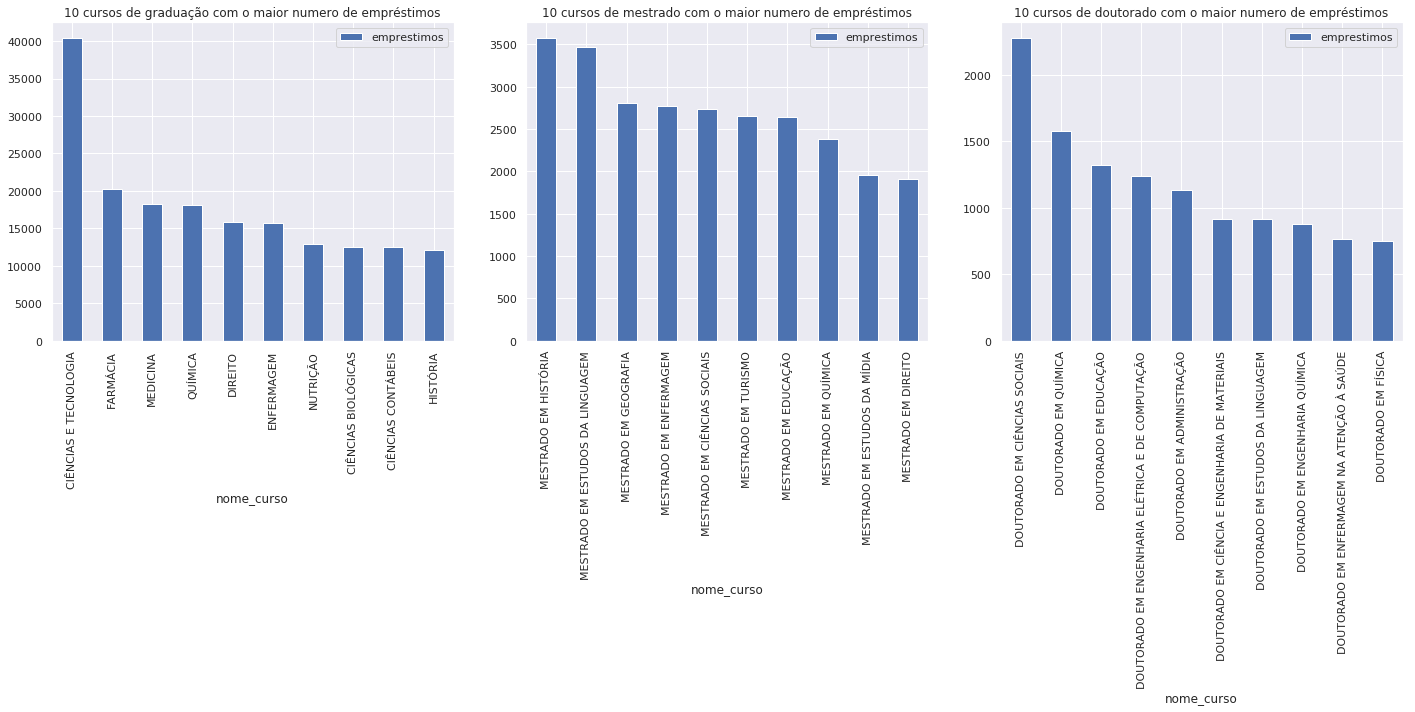

In [14]:
# Preparando Gráficos para os niveis comuns de ensino
niveis_ensino_padrao = ["GRADUAÇÃO", "MESTRADO", "DOUTORADO"]

fig, axes = plt.subplots(figsize=(20, 10),nrows=1, ncols=3)

generic_title = "10 cursos de %s com o maior numero de empréstimos"

for i in range(len(niveis_ensino_padrao)):
    emprestimos_curso_niveis[niveis_ensino_padrao[i]].head(10).plot.bar(title=generic_title % niveis_ensino_padrao[i].lower(), ax=axes[i])

plt.tight_layout()
plt.show()

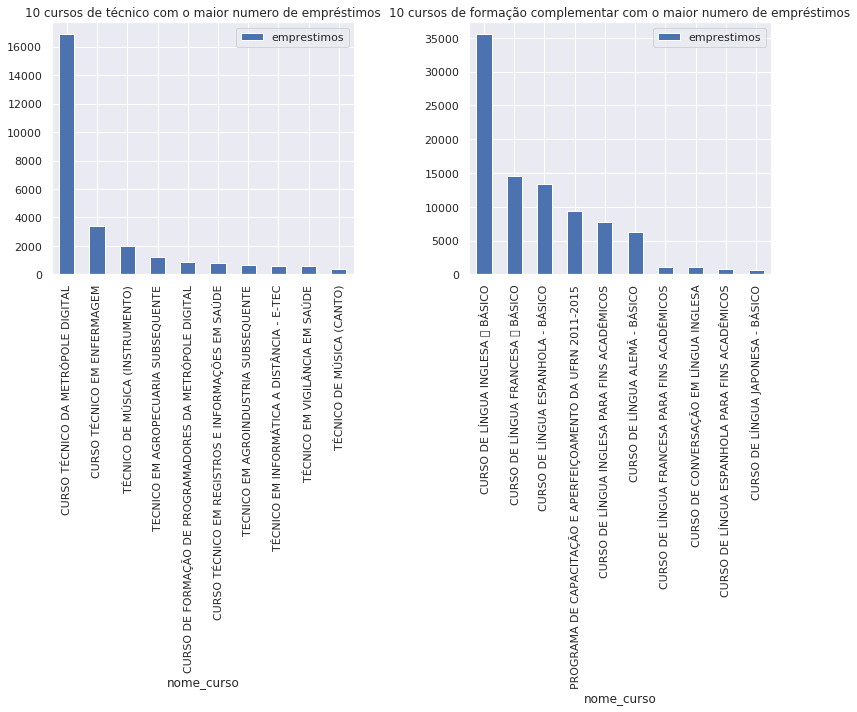

In [15]:
# Preparando Gráficos para os outros niveis de ensino
niveis_ensino_outros = ["TÉCNICO","FORMAÇÃO COMPLEMENTAR"]

fig, axes = plt.subplots(figsize=(12, 10),nrows=1, ncols=2)

for i in range(len(niveis_ensino_outros)):
    emprestimos_curso_niveis[niveis_ensino_outros[i]].head(10).plot.bar(title=generic_title % niveis_ensino_outros[i].lower(), ax=axes[i])
    
plt.tight_layout()
plt.show()

In [16]:
# Contabilizando numero de emprestimos por ano
emprestimos_ano = emprestimos_all.groupby(["ano"])["id_emprestimo"].count()
emprestimos_ano = pd.DataFrame(emprestimos_ano)

In [17]:
# Melhorando o nome da coluna para o plot
emprestimos_ano.columns = ["Emprestimos"]

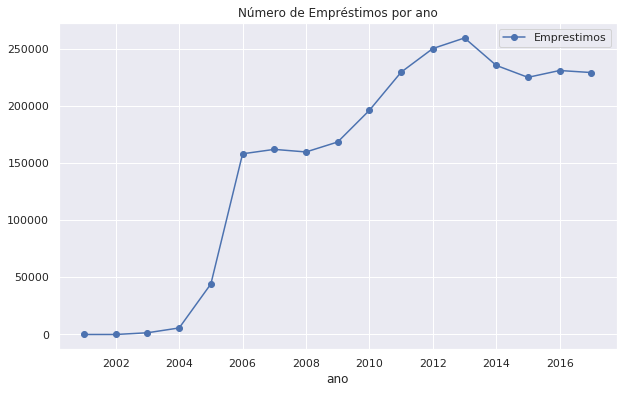

In [18]:
# Plot de linha do andamento dos emprestimos nos anos
emprestimos_ano.plot(kind='line', title="Número de Empréstimos por ano", legend=True, figsize=(10,6), style=["o-"])

In [24]:
# Preparando os dados dos exemplares emprestados
codigos_livros_emprestados = emprestimos_all.codigo_barras.value_counts()
codigos_livros_emprestados = pd.DataFrame(codigos_livros_emprestados)
codigos_livros_emprestados = codigos_livros_emprestados.reset_index()
codigos_livros_emprestados.columns = ["codigo_barras", "count"]

In [21]:
# Simplificando os dados do acervo, selecionando algumas colunas
bib_ex = exemplares[["registro_sistema", "codigo_barras"]]
exe_acer = exemplares_acervo[["registro_sistema", "titulo", "sub_titulo"]]

In [28]:
# Realizando o merge dos dados sobre o acervo com base no registro do sistema.
biblio_merged = pd.merge(bib_ex, exe_acer, on="registro_sistema", how='outer')
biblio_merged = biblio_merged.drop_duplicates(subset="codigo_barras")

In [29]:
# Merge com base nos exemplares emprestados e seus dados no acervo, identificando os titulos
biblio_merged_counted = pd.merge(codigos_livros_emprestados, biblio_merged, on="codigo_barras")

In [30]:
biblio_merged_counted.head()

,codigo_barras,count,registro_sistema,titulo,sub_titulo
0,2006039067,237,70862,Patologia oral & maxilofacial /,NaN
1,X007747,209,37351,Cálculo :,um novo horizonte /
2,L184372,166,45093,Um curso de cálculo /,NaN
3,X007959,165,45093,Um curso de cálculo /,NaN
4,X007748,162,52119,Álgebra linear com aplicações /,NaN


In [14]:
emprestimos_simples = emprestimos_all[['codigo_barras', 'data_emprestimo','data_devolucao', 'nome_usuario']]

In [12]:
emprestimos_simples.head()

,codigo_barras,data_emprestimo,data_devolucao,nome_usuario
26,L129432,2001-06-11 12:01:00,2014-05-06 16:53:45,ANNA KARINNA CAVALCANTE DA SILVA
249,L106353,2002-10-18 12:01:00,2015-10-27 17:41:30,SIMONE SUELI NOBRE DA SILVA
298,L156111,2003-04-02 12:01:00,2015-10-27 17:43:20,LUCIANA APARECIDA COSME SOARES
299,L155829,2003-04-02 12:01:00,2015-10-27 17:43:39,LUCIANA APARECIDA COSME SOARES
498,O005923,2003-09-22 17:44:00,2003-09-22 17:44:00,WELLINGTON RODRIGUES DA SILVA


In [15]:
emprestimos_reg_sistema = pd.merge(emprestimos_simples, bib_ex, on="codigo_barras", how='inner')

In [16]:
emprestimos_reg_sistema_sorted = emprestimos_reg_sistema.sort_values(["nome_usuario", "registro_sistema"])

In [17]:
emprestimos_reg_sistema_sorted["tempo_com_livro"] = (pd.to_datetime(emprestimos_reg_sistema_sorted["data_devolucao"]) - pd.to_datetime(emprestimos_reg_sistema_sorted["data_emprestimo"]))

In [22]:
tempo_usuarios_livros = emprestimos_reg_sistema_sorted.groupby("nome_usuario")["tempo_com_livro"].sum()

In [23]:
# Dados interessantes sobre o tempo dos emprestimos de cada usuario
tempo_usuarios_livros = tempo_usuarios_livros.sort_values(ascending=False)
tempo_usuarios_livros.describe()

count                         77511
mean       695 days 06:59:32.561276
std        855 days 20:36:34.414507
min                 0 days 00:00:00
25%        131 days 23:11:38.054500
50%        401 days 01:02:50.492000
75%        951 days 17:19:27.820500
max      18458 days 01:28:42.583000
Name: tempo_com_livro, dtype: object

In [27]:
tempo_usuarios_livros.head()

nome_usuario
ADAILSON TAVARES DE MACEDO                 18458 days 01:28:42.583000
UILIETE MARCIA SILVA DE MENDONCA PEREIRA   15156 days 06:34:07.974999
JOIS ALBERTO DA SILVA                      14419 days 14:19:01.189999
ADRIANO CHARLES DA SILVA CRUZ              13627 days 06:35:04.051000
GILSON GOMES DA SILVA                      12215 days 17:01:56.171000
Name: tempo_com_livro, dtype: timedelta64[ns]

In [18]:
emprestimos_reg_sistema_sorted["dias_com_livro"] = emprestimos_reg_sistema_sorted["tempo_com_livro"].dt.days

In [26]:
emprestimos_reg_sistema_sorted.head()

,codigo_barras,data_emprestimo,data_devolucao,nome_usuario,registro_sistema,localizacao,tempo_com_livro,dias_com_livro
1121582,2009047344,2011-03-25 16:16:05.567,2011-03-28 17:08:36,\tFRANCISCO MOURA DO VALE NETO\t,71506,53 N975c 4.ed. v.1,3 days 00:52:30.433000,3.0
1173670,2010000636,2012-04-20 14:34:47.912,2012-05-09 13:49:38,\tFRANCISCO MOURA DO VALE NETO\t,71506,53 N975c 4.ed. v.1,18 days 23:14:50.088000,18.0
1241420,2010043993,2013-08-21 12:40:12.088,2013-09-05 12:37:27,\tFRANCISCO MOURA DO VALE NETO\t,123525,53 S492p 1.ed. v.3,14 days 23:57:14.912000,14.0
1433228,2010094282,2013-09-13 14:44:56.049,2013-10-15 12:43:14,\tFRANCISCO MOURA DO VALE NETO\t,162354,53 H188f 8.ed. v.3,31 days 21:58:17.951000,31.0
1490146,2011033261,2013-05-02 10:44:03.998,2013-06-03 18:19:55,\tFRANCISCO MOURA DO VALE NETO\t,165526,53 Y72f 12.ed. v.2,32 days 07:35:51.002000,32.0


In [21]:
to_plot = emprestimos_reg_sistema_sorted[(emprestimos_reg_sistema_sorted.dias_com_livro <= 60) & (emprestimos_reg_sistema_sorted.dias_com_livro > 0)]

In [22]:
to_plot = to_plot[["codigo_barras", "dias_com_livro"]]

In [23]:
to_plot.columns = ["Código de Barras", "Dias com o Livro"]

/home/johnvithor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Frequencia dos Tempos dos Emprestimos')

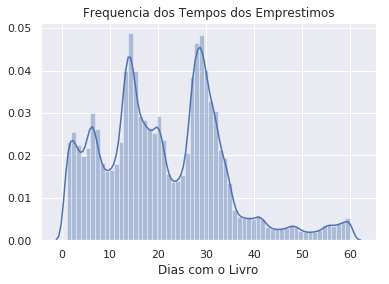

In [33]:
g = sns.distplot(to_plot["Dias com o Livro"], bins=60)
g.set_title("Frequencia dos Tempos dos Emprestimos")
#to_plot.plot.hist(x="Código de Barras", y="Dias com o Livro", bins=60, legend=False, title="Frequencia dos Tempos dos Emprestimos ")

In [36]:
emprestimos_reg_sistema_sorted.head()

,codigo_barras,data_emprestimo,data_devolucao,nome_usuario,registro_sistema,localizacao,tempo_com_livro,dias_com_livro
1121582,2009047344,2011-03-25 16:16:05.567,2011-03-28 17:08:36,\tFRANCISCO MOURA DO VALE NETO\t,71506,53 N975c 4.ed. v.1,3 days 00:52:30.433000,3.0
1173670,2010000636,2012-04-20 14:34:47.912,2012-05-09 13:49:38,\tFRANCISCO MOURA DO VALE NETO\t,71506,53 N975c 4.ed. v.1,18 days 23:14:50.088000,18.0
1241420,2010043993,2013-08-21 12:40:12.088,2013-09-05 12:37:27,\tFRANCISCO MOURA DO VALE NETO\t,123525,53 S492p 1.ed. v.3,14 days 23:57:14.912000,14.0
1433228,2010094282,2013-09-13 14:44:56.049,2013-10-15 12:43:14,\tFRANCISCO MOURA DO VALE NETO\t,162354,53 H188f 8.ed. v.3,31 days 21:58:17.951000,31.0
1490146,2011033261,2013-05-02 10:44:03.998,2013-06-03 18:19:55,\tFRANCISCO MOURA DO VALE NETO\t,165526,53 Y72f 12.ed. v.2,32 days 07:35:51.002000,32.0
1515416,2011024193,2013-05-02 10:44:04.043,2013-06-03 18:19:53,\tFRANCISCO MOURA DO VALE NETO\t,165526,53 Y72f 12.ed. v.3,32 days 07:35:48.957000,32.0
1493690,2011033142,2012-01-13 14:44:46.166,2012-02-13 14:21:25,\tFRANCISCO MOURA DO VALE NETO\t,167086,517.2/.3 T456c 11.ed. v.2,30 days 23:36:38.834000,30.0
1585636,2011046538,2013-04-01 09:53:15.2,2013-05-02 10:35:43,\tFRANCISCO MOURA DO VALE NETO\t,169092,53 T595f 6.ed. v.1,31 days 00:42:27.800000,31.0
1650247,2011078610,2013-02-18 10:59:01.183,2013-03-20 10:09:04,\tFRANCISCO MOURA DO VALE NETO\t,169092,53 T595f 6.ed. v.1,29 days 23:10:02.817000,29.0
1656270,2011078784,2013-02-18 10:59:01.215,2013-03-20 10:08:59,\tFRANCISCO MOURA DO VALE NETO\t,169092,53 T595f 6.ed. v.2,29 days 23:09:57.785000,29.0


In [73]:
livros_mais_dias = emprestimos_reg_sistema_sorted.groupby("registro_sistema")["dias_com_livro"].sum()

In [32]:
acervo_basic = exemplares_acervo[["registro_sistema", "titulo", "sub_titulo", "assunto"]]

In [74]:
livros_mais_dias = pd.DataFrame(livros_mais_dias.sort_values(ascending=False))
livros_mais_dias = livros_mais_dias.reset_index()

In [37]:
a = emprestimos_reg_sistema_sorted.registro_sistema.value_counts()

In [38]:
b = pd.DataFrame(a)

In [39]:
c = b.reset_index()

In [40]:
c.columns = ["registro_sistema","Emprestimos"]

In [75]:
livros_mais_dias.columns = ["registro_sistema", "dias_com_livro"]

In [99]:
livros_interessantes = pd.merge(livros_mais_dias, acervo_basic, on="registro_sistema")

In [100]:
livros_interessantes = livros_interessantes[livros_interessantes.dias_com_livro > 0]

In [101]:
livros_interessantes_plot = livros_interessantes[["titulo", "dias_com_livro"]]

In [102]:
livros_interessantes_plot_d = livros_interessantes_plot.drop_duplicates("titulo")

In [103]:
livros_interessantes_plot_d.columns = ["Titulo", "Dias com o Livro"]

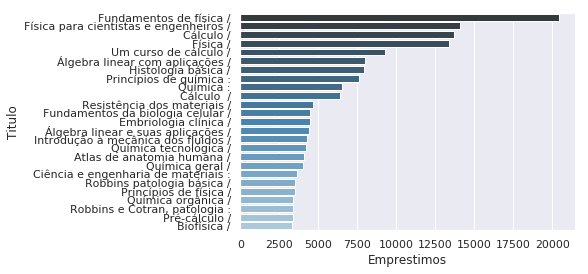

In [97]:
g = sns.barplot(data=livros_interessantes_plot_d.head(25), x="Emprestimos", y="Titulo", palette="Blues_d", orient="h")
#g.set_title("Número de Empréstimos por Título")
#g.set_xticklabels(g.get_xticklabels(), rotation=90)
#livros_interessantes_plot_d[(livros_interessantes_plot_d["Dias com o Livro"] <= 100)].plot.hist(bins=100, figsize=(10,6), title = "Tempo de Empréstimo por Título")
plt.show()

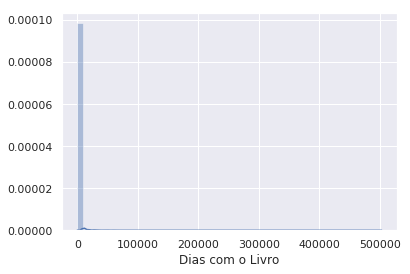

In [104]:
sns.distplot(livros_interessantes_plot_d["Dias com o Livro"])
#livros_interessantes_plot_d[livros_interessantes_plot_d["Dias com o Livro"] < 300].plot.hist()

In [105]:
livros_25 = livros_interessantes_plot_d.set_index("Titulo").head(25)

In [106]:
livros_25["Anos com o Livro"] = livros_25["Dias com o Livro"]/365

In [107]:
livros_25 = livros_25.reset_index()

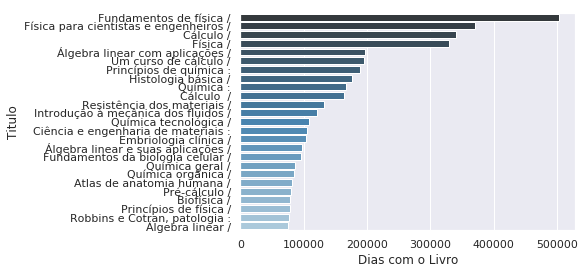

In [109]:
sns.barplot(data=livros_25, x="Dias com o Livro", y="Titulo", palette="Blues_d")
g.set_title("Titulos com mais tempo de emprestimo")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()